In [6]:
!pip install torch
#!pip install python-dotenv
#!pip install mysqlclient
!pip install --pre deepchem[tensorflow]
!pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 35.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [7]:
import pandas as pd
import os
import requests
import json
import csv
import io
import re
from collections import defaultdict
from time import time
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sqlalchemy import create_engine
from sqlalchemy import text
import sql
import deepchem as dc
import numpy as np
import tensorflow as tf
from tensorflow import keras
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, PyMol, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
from deepchem import metrics
from IPython.display import Image, display
from rdkit.Chem.Draw import SimilarityMaps
import seaborn
from matplotlib.pyplot import hist
from sklearn.neighbors import KernelDensity
from scipy import stats
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from scipy.cluster.hierarchy import dendrogram
from sklearn.feature_extraction.text import TfidfTransformer
from typing import List

In [10]:
# Set disease_id variable for desired disease
#at somepoint include api to chose what disease one wants from : https://www.ebi.ac.uk/efo/
disease_id = "EFO_0005537"

disease_url = 'http://mount.eastus.cloudapp.azure.com:1808/disease/{disease_id}'

disease_df = pd.read_json(disease_url.format(disease_id = disease_id))

#displaying the dataframe
display(disease_df)
target_ids = disease_df.sort_values(by = ['association_score'], ascending=False)['target_ensemble_id'].values

,index,disease_id,target_ensemble_id,target_chembl_id,association_score
0,0,EFO_0005537,ENSG00000184292,CHEMBL3856163,0.431490
1,1,EFO_0005537,ENSG00000198900,CHEMBL1781,0.424207
2,2,EFO_0005537,ENSG00000120217,CHEMBL3580522,0.405569
3,3,EFO_0005537,ENSG00000258947,CHEMBL2597,0.402827
4,4,EFO_0005537,ENSG00000137267,CHEMBL3797012,0.399973
...,...,...,...,...,...
5012,5012,EFO_0005537,ENSG00000135164,CHEMBL3707469,0.001478
5013,5013,EFO_0005537,ENSG00000115665,CHEMBL4507,0.001478
5014,5014,EFO_0005537,ENSG00000146109,CHEMBL4507,0.001478
5015,5015,EFO_0005537,ENSG00000225830,CHEMBL4507,0.001478


In [11]:

# example target_id from target_to_compounds database
target_id = "ENSG00000196230"

target_url = 'http://mount.eastus.cloudapp.azure.com:1808/targets/{target_id}'

target_to_compounds_df = pd.read_json(target_url.format(target_id = target_id))

#show dataframe
display(target_to_compounds_df)

,index,compound_id,smiles,type,standard_value,assay_id,assay_type,assay_description,document_id,abstract,target_ensemble_id
0,0,CHEMBL4128424,O=C(COc1ccc2c(-c3ccccc3)cc(=O)oc2c1)NN1C(=O)CS...,IC50,2890,CHEMBL4123910,B,Inhibition of tubulin beta polymerization in h...,CHEMBL4118208,A new set of 4-phenylcoumarin derivatives was ...,ENSG00000196230
1,1,CHEMBL107,COc1cc2c(c(OC)c1OC)-c1ccc(OC)c(=O)cc1[C@@H](NC...,IC50,4590,CHEMBL4259781,B,Inhibition of tubulin beta polymerization in h...,CHEMBL4257538,"A novel series of sulfonamide derivatives, cou...",ENSG00000196230
2,2,CHEMBL4127437,COc1cc(C2SCC(=O)N2NC(=O)COc2ccc3c(-c4ccccc4)cc...,IC50,6130,CHEMBL4123910,B,Inhibition of tubulin beta polymerization in h...,CHEMBL4118208,A new set of 4-phenylcoumarin derivatives was ...,ENSG00000196230
3,3,CHEMBL4278069,O=C(NCc1ccc(S(=O)(=O)NCc2ccccc2)cc1)c1cc(Cl)ccc1O,IC50,6440,CHEMBL4259780,B,Inhibition of tubulin beta polymerization in h...,CHEMBL4257538,"A novel series of sulfonamide derivatives, cou...",ENSG00000196230
4,4,CHEMBL107,COc1cc2c(c(OC)c1OC)-c1ccc(OC)c(=O)cc1[C@@H](NC...,IC50,6930,CHEMBL4123910,B,Inhibition of tubulin beta polymerization in h...,CHEMBL4118208,A new set of 4-phenylcoumarin derivatives was ...,ENSG00000196230
5,5,CHEMBL107,COc1cc2c(c(OC)c1OC)-c1ccc(OC)c(=O)cc1[C@@H](NC...,IC50,7710,CHEMBL4259780,B,Inhibition of tubulin beta polymerization in h...,CHEMBL4257538,"A novel series of sulfonamide derivatives, cou...",ENSG00000196230
6,6,CHEMBL4129198,O=C(COc1ccc2c(-c3ccccc3)cc(=O)oc2c1)NN1C(=O)CS...,IC50,9370,CHEMBL4123910,B,Inhibition of tubulin beta polymerization in h...,CHEMBL4118208,A new set of 4-phenylcoumarin derivatives was ...,ENSG00000196230
7,7,CHEMBL4284188,O=C(NCc1ccc(S(=O)(=O)Nc2ccc(Cl)cc2)cc1)c1cc(Cl...,IC50,29310,CHEMBL4259781,B,Inhibition of tubulin beta polymerization in h...,CHEMBL4257538,"A novel series of sulfonamide derivatives, cou...",ENSG00000196230


In [12]:
%env XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda

env: XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda


In [13]:
# 1. Train Model
print(tf.version.VERSION)

compound_dataset = target_to_compounds_df
smiles = compound_dataset['smiles']
IC50 = compound_dataset['standard_value']
featurizer = dc.feat.ConvMolFeaturizer()
compound_dataset['featurized'] = featurizer.featurize(smiles)
compound_dataset['divided values'] = compound_dataset['standard_value'].astype(float).div(max(compound_dataset['standard_value'].astype(float)))
compound_dataset['pIC50'] = np.log10(compound_dataset['divided values'].astype(float)).mul(-1)
compound_dataset['number'] = list(range(0,len(compound_dataset)))
display(compound_dataset)

training_dataset = compound_dataset.sample(frac = 0.7)
testing_dataset = (compound_dataset[~compound_dataset['number'].isin(training_dataset['number'])])
display(testing_dataset)

numpy_training_dataset = dc.data.NumpyDataset(X=training_dataset['featurized'],y=training_dataset['pIC50'].astype(float), ids=training_dataset['smiles'])
numpy_testing_dataset = dc.data.NumpyDataset(X=testing_dataset['featurized'],y=testing_dataset['pIC50'].astype(float), ids=testing_dataset['smiles'])
display(numpy_training_dataset)
display(numpy_testing_dataset)
#using  the graph convolution model
model = dc.models.GraphConvModel(n_tasks=1, mode='regression', dropout=0.2, dense_layer_size=10)
model.fit(numpy_training_dataset, nb_epoch=1)#was 100 on instance

metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print("Training set score:", model.evaluate(numpy_training_dataset, [metric]))
print("Test set score:", model.evaluate(numpy_testing_dataset, [metric]))
#end of Training the model

2.15.0


,index,compound_id,smiles,type,standard_value,assay_id,assay_type,assay_description,document_id,abstract,target_ensemble_id,featurized,divided values,pIC50,number
0,0,CHEMBL4128424,O=C(COc1ccc2c(-c3ccccc3)cc(=O)oc2c1)NN1C(=O)CS...,IC50,2890,CHEMBL4123910,B,Inhibition of tubulin beta polymerization in h...,CHEMBL4118208,A new set of 4-phenylcoumarin derivatives was ...,ENSG00000196230,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.098601,1.006118,0
1,1,CHEMBL107,COc1cc2c(c(OC)c1OC)-c1ccc(OC)c(=O)cc1[C@@H](NC...,IC50,4590,CHEMBL4259781,B,Inhibition of tubulin beta polymerization in h...,CHEMBL4257538,"A novel series of sulfonamide derivatives, cou...",ENSG00000196230,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.156602,0.805203,1
2,2,CHEMBL4127437,COc1cc(C2SCC(=O)N2NC(=O)COc2ccc3c(-c4ccccc4)cc...,IC50,6130,CHEMBL4123910,B,Inhibition of tubulin beta polymerization in h...,CHEMBL4118208,A new set of 4-phenylcoumarin derivatives was ...,ENSG00000196230,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.209144,0.679555,2
3,3,CHEMBL4278069,O=C(NCc1ccc(S(=O)(=O)NCc2ccccc2)cc1)c1cc(Cl)ccc1O,IC50,6440,CHEMBL4259780,B,Inhibition of tubulin beta polymerization in h...,CHEMBL4257538,"A novel series of sulfonamide derivatives, cou...",ENSG00000196230,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.219720,0.658130,3
4,4,CHEMBL107,COc1cc2c(c(OC)c1OC)-c1ccc(OC)c(=O)cc1[C@@H](NC...,IC50,6930,CHEMBL4123910,B,Inhibition of tubulin beta polymerization in h...,CHEMBL4118208,A new set of 4-phenylcoumarin derivatives was ...,ENSG00000196230,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.236438,0.626283,4
5,5,CHEMBL107,COc1cc2c(c(OC)c1OC)-c1ccc(OC)c(=O)cc1[C@@H](NC...,IC50,7710,CHEMBL4259780,B,Inhibition of tubulin beta polymerization in h...,CHEMBL4257538,"A novel series of sulfonamide derivatives, cou...",ENSG00000196230,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.263050,0.579961,5
6,6,CHEMBL4129198,O=C(COc1ccc2c(-c3ccccc3)cc(=O)oc2c1)NN1C(=O)CS...,IC50,9370,CHEMBL4123910,B,Inhibition of tubulin beta polymerization in h...,CHEMBL4118208,A new set of 4-phenylcoumarin derivatives was ...,ENSG00000196230,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.319686,0.495276,6
7,7,CHEMBL4284188,O=C(NCc1ccc(S(=O)(=O)Nc2ccc(Cl)cc2)cc1)c1cc(Cl...,IC50,29310,CHEMBL4259781,B,Inhibition of tubulin beta polymerization in h...,CHEMBL4257538,"A novel series of sulfonamide derivatives, cou...",ENSG00000196230,<deepchem.feat.mol_graphs.ConvMol object at 0x...,1.000000,-0.000000,7


,index,compound_id,smiles,type,standard_value,assay_id,assay_type,assay_description,document_id,abstract,target_ensemble_id,featurized,divided values,pIC50,number
2,2,CHEMBL4127437,COc1cc(C2SCC(=O)N2NC(=O)COc2ccc3c(-c4ccccc4)cc...,IC50,6130,CHEMBL4123910,B,Inhibition of tubulin beta polymerization in h...,CHEMBL4118208,A new set of 4-phenylcoumarin derivatives was ...,ENSG00000196230,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.209144,0.679555,2
4,4,CHEMBL107,COc1cc2c(c(OC)c1OC)-c1ccc(OC)c(=O)cc1[C@@H](NC...,IC50,6930,CHEMBL4123910,B,Inhibition of tubulin beta polymerization in h...,CHEMBL4118208,A new set of 4-phenylcoumarin derivatives was ...,ENSG00000196230,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.236438,0.626283,4


<NumpyDataset X.shape: (6,), y.shape: (6,), w.shape: (6,), ids: ['O=C(COc1ccc2c(-c3ccccc3)cc(=O)oc2c1)NN1C(=O)CSC1c1ccc(F)cc1'
 'O=C(COc1ccc2c(-c3ccccc3)cc(=O)oc2c1)NN1C(=O)CSC1c1ccc(Cl)cc1'
 'COc1cc2c(c(OC)c1OC)-c1ccc(OC)c(=O)cc1[C@@H](NC(C)=O)CC2'
 'O=C(NCc1ccc(S(=O)(=O)NCc2ccccc2)cc1)c1cc(Cl)ccc1O'
 'O=C(NCc1ccc(S(=O)(=O)Nc2ccc(Cl)cc2)cc1)c1cc(Cl)ccc1O'
 'COc1cc2c(c(OC)c1OC)-c1ccc(OC)c(=O)cc1[C@@H](NC(C)=O)CC2'], task_names: [0]>

<NumpyDataset X.shape: (2,), y.shape: (2,), w.shape: (2,), ids: ['COc1cc(C2SCC(=O)N2NC(=O)COc2ccc3c(-c4ccccc4)cc(=O)oc3c2)cc(OC)c1OC'
 'COc1cc2c(c(OC)c1OC)-c1ccc(OC)c(=O)cc1[C@@H](NC(C)=O)CC2'], task_names: [0]>

Training set score: {'pearson_r2_score': 0.02072617426596233}
Test set score: {'pearson_r2_score': 1.0}


In [39]:
#2. Download all compounds in database

# Load data
compounds_df = pd.read_json('http://mount.eastus.cloudapp.azure.com:1808/compounds')

# Initialize the 'predicted_pIC50' column with None
predict_list = []
for smile in range(0, len(compounds_df)):
    predict_list.append(None)

compounds_df['predicted_pIC50'] = predict_list

# Drop rows with NaN values in the 'smiles' column and create a copy (newly added)
curated_compounds_df = compounds_df.dropna(subset=['smiles']).copy()

# Extract 'smiles' column
new_smiles = curated_compounds_df['smiles']

# Featurize the 'smiles' column and assign to a new column 'featurized' using .loc[]
curated_compounds_df.loc[:, 'featurized'] = featurizer.featurize(new_smiles)

display(curated_compounds_df)

,compound_id,smiles,target_ensemble_id,predicted_pIC50,featurized
0,CHEMBL570841,N=C1NC(=O)/C(=C/c2ccc(O)cc2)S1,ENSG00000020922,None,<deepchem.feat.mol_graphs.ConvMol object at 0x...
1,CHEMBL570841,N=C1NC(=O)/C(=C/c2ccc(O)cc2)S1,ENSG00000020922,None,<deepchem.feat.mol_graphs.ConvMol object at 0x...
2,CHEMBL4128424,O=C(COc1ccc2c(-c3ccccc3)cc(=O)oc2c1)NN1C(=O)CS...,ENSG00000196230,None,<deepchem.feat.mol_graphs.ConvMol object at 0x...
3,CHEMBL107,COc1cc2c(c(OC)c1OC)-c1ccc(OC)c(=O)cc1[C@@H](NC...,ENSG00000196230,None,<deepchem.feat.mol_graphs.ConvMol object at 0x...
4,CHEMBL4127437,COc1cc(C2SCC(=O)N2NC(=O)COc2ccc3c(-c4ccccc4)cc...,ENSG00000196230,None,<deepchem.feat.mol_graphs.ConvMol object at 0x...
...,...,...,...,...,...
13747,CHEMBL7976,O=C(/C=C/c1ccccc1)c1ccccc1,ENSG00000261456,None,<deepchem.feat.mol_graphs.ConvMol object at 0x...
13748,CHEMBL107,COc1cc2c(c(OC)c1OC)-c1ccc(OC)c(=O)cc1[C@@H](NC...,ENSG00000261456,None,<deepchem.feat.mol_graphs.ConvMol object at 0x...
13749,CHEMBL18869,COc1cccc(-c2nc(O)c3cc(OC)ccc3n2)c1,ENSG00000261456,None,<deepchem.feat.mol_graphs.ConvMol object at 0x...
13750,CHEMBL278647,COc1cccc(-c2nc(O)c3cc(OC)c(OC)cc3n2)c1,ENSG00000261456,None,<deepchem.feat.mol_graphs.ConvMol object at 0x...


In [40]:
"""3. run the model to predict ic50 values for each compound in the database
dataset = dc.data.NumpyDataset(X=curated_compounds_df['featurized'], y=curated_compounds_df['predicted_pIC50'], ids=curated_compounds_df['smiles'])
curated_compounds_df['predicted_pIC50'] = model.predict(dataset)
"""
#3. run the model to predict pic50 values for compounds that are not associated with the target
curated_compounds_no_target = curated_compounds_df[~curated_compounds_df['smiles'].isin(target_to_compounds_df['smiles'])]
dataset = dc.data.NumpyDataset(X=curated_compounds_no_target['featurized'], y=curated_compounds_no_target['predicted_pIC50'], ids=curated_compounds_no_target['smiles'])
curated_compounds_no_target.loc[:, 'predicted_pIC50'] = model.predict(dataset)

In [41]:
# 4. displays a dataframe that has the following two columns : compound, predicted ic50
#display(curated_compounds_df)
display(curated_compounds_no_target)

,compound_id,smiles,target_ensemble_id,predicted_pIC50,featurized
0,CHEMBL570841,N=C1NC(=O)/C(=C/c2ccc(O)cc2)S1,ENSG00000020922,0.932275,<deepchem.feat.mol_graphs.ConvMol object at 0x...
1,CHEMBL570841,N=C1NC(=O)/C(=C/c2ccc(O)cc2)S1,ENSG00000020922,0.932275,<deepchem.feat.mol_graphs.ConvMol object at 0x...
10,CHEMBL193952,Cc1cn([C@H]2C[C@H](N=[N+]=[N-])[C@@H](COP(=O)(...,ENSG00000062822,1.632659,<deepchem.feat.mol_graphs.ConvMol object at 0x...
11,CHEMBL2011646,C/C=C/C1=CC2=CC(=O)[C@@](C)(OC(=O)c3c(C)cc(O)c...,ENSG00000062822,0.79915,<deepchem.feat.mol_graphs.ConvMol object at 0x...
12,CHEMBL2011648,C/C=C/C1=CC2=CC(=O)[C@@](C)(O)[C@@H](OC(=O)c3c...,ENSG00000062822,0.784998,<deepchem.feat.mol_graphs.ConvMol object at 0x...
...,...,...,...,...,...
13746,CHEMBL67,COc1ccc(/C=C\c2cc(OC)c(OC)c(OC)c2)cc1O,ENSG00000261456,0.629073,<deepchem.feat.mol_graphs.ConvMol object at 0x...
13747,CHEMBL7976,O=C(/C=C/c1ccccc1)c1ccccc1,ENSG00000261456,0.96769,<deepchem.feat.mol_graphs.ConvMol object at 0x...
13749,CHEMBL18869,COc1cccc(-c2nc(O)c3cc(OC)ccc3n2)c1,ENSG00000261456,1.089157,<deepchem.feat.mol_graphs.ConvMol object at 0x...
13750,CHEMBL278647,COc1cccc(-c2nc(O)c3cc(OC)c(OC)cc3n2)c1,ENSG00000261456,1.083487,<deepchem.feat.mol_graphs.ConvMol object at 0x...


In [49]:
# 5. print out the compound that has the highest ic50 value that has NOT been tested on the target already.
import pandas as pd


# Filter out compounds that are in target_to_compounds_df
#curated_compounds_no_target = curated_compounds_df[~curated_compounds_df['smiles'].isin(target_to_compounds_df['smiles'])]

# Sort the resulting DataFrame by 'predicted_pIC50' in descending order
df = curated_compounds_no_target.sort_values(by=['predicted_pIC50'], ascending=False)

# Drop duplicates based on 'smiles' column
df.drop_duplicates(subset='smiles', inplace=True)

# Display the final DataFrame
display(df)

# Extract 'compound_id' and 'smiles' values
compound_ids = df['compound_id'].values
compound_smiles = df['smiles'].values

# Create a list of tuples containing 'compound_id' and 'smiles'
compound_ids_and_smiles = list(zip(compound_ids, compound_smiles))

# Print the list of tuples
print(compound_ids_and_smiles)

# Select the best compound (the first one in the list)
best_compound = compound_ids_and_smiles[0]
print("Best Compound:", best_compound)

,compound_id,smiles,target_ensemble_id,predicted_pIC50,featurized
6809,CHEMBL209511,O=S(=O)(Nc1ccc(Cl)cc1O)c1ccccc1,ENSG00000141736,1.94692,<deepchem.feat.mol_graphs.ConvMol object at 0x...
10312,CHEMBL125,CCCCCCCCCCCCCCCCOP(=O)([O-])OCC[N+](C)(C)C,ENSG00000142208,1.901621,<deepchem.feat.mol_graphs.ConvMol object at 0x...
6500,CHEMBL1828860,Cc1ncc([N+](=O)[O-])n1CC(=O)NS(=O)(=O)c1ccccc1,ENSG00000141736,1.868068,<deepchem.feat.mol_graphs.ConvMol object at 0x...
12065,CHEMBL3330409,CCc1ccccc1C(C(=O)Nc1ccc2[nH]nc(-c3cccc(S(N)(=O...,ENSG00000183765,1.844081,<deepchem.feat.mol_graphs.ConvMol object at 0x...
2962,CHEMBL3691652,CN(C)C(=O)c1cc2cnc(Nc3ccc(N4CCCC5(CCNCC5)C4=O)...,ENSG00000135446,1.837528,<deepchem.feat.mol_graphs.ConvMol object at 0x...
...,...,...,...,...,...
6116,CHEMBL231099,COCCOc1cc2ncnc(Nc3ccc(OC4CCN(C(=O)Nc5c(F)cccc5...,ENSG00000141736,0.225334,<deepchem.feat.mol_graphs.ConvMol object at 0x...
1481,CHEMBL5077271,CC(C)N1CCN(C(=O)c2ccc(Nc3ncc(F)c(-c4ccc5ncc(N(...,ENSG00000105810,0.221636,<deepchem.feat.mol_graphs.ConvMol object at 0x...
1549,CHEMBL5091949,CC(C)N1CCN(C(=O)c2ccc(Nc3nccc(-c4ccc5ncc(N(C)C...,ENSG00000105810,0.20767,<deepchem.feat.mol_graphs.ConvMol object at 0x...
5079,CHEMBL109480,C=CCNC1=C2C[C@@H](C)C[C@H](OC)[C@H](O)[C@@H](C...,ENSG00000141736,0.203302,<deepchem.feat.mol_graphs.ConvMol object at 0x...


[('CHEMBL209511', 'O=S(=O)(Nc1ccc(Cl)cc1O)c1ccccc1'), ('CHEMBL125', 'CCCCCCCCCCCCCCCCOP(=O)([O-])OCC[N+](C)(C)C'), ('CHEMBL1828860', 'Cc1ncc([N+](=O)[O-])n1CC(=O)NS(=O)(=O)c1ccccc1'), ('CHEMBL3330409', 'CCc1ccccc1C(C(=O)Nc1ccc2[nH]nc(-c3cccc(S(N)(=O)=O)c3)c2c1)N(C)C'), ('CHEMBL3691652', 'CN(C)C(=O)c1cc2cnc(Nc3ccc(N4CCCC5(CCNCC5)C4=O)cn3)nc2n1C1CCCC1'), ('CHEMBL3691651', 'CN(C)C(=O)c1cc2cnc(Nc3ccc(N4CCC5(CCCN5C(=O)OC(C)(C)C)C4=O)cn3)nc2n1C1CCCC1'), ('CHEMBL511520', 'CCc1cc2c(N/N=C\\C(C)(C)C)ncnc2s1'), ('CHEMBL1773606', 'CC(=O)Nc1nc2ccc(-c3cnc(Cl)c(NS(=O)(=O)c4ccccc4C(F)(F)F)c3)cc2s1'), ('CHEMBL595582', 'CCCCCCCCCC(=O)Nc1ccc(S(=O)(=O)Nc2nncs2)cc1'), ('CHEMBL1773605', 'CC(=O)Nc1nc2ccc(-c3cnc(Cl)c(NS(=O)(=O)c4ccccc4)c3)cc2s1'), ('CHEMBL3696241', 'CC(C)(C)c1cccc(NC(=O)Cc2nc(N3CCOCC3)cc(=O)[nH]2)c1'), ('CHEMBL451318', 'CC(C)=CCC/C(C)=C/CC/C(C)=C/CC/C(C)=C/CC/C(C)=C/CC/C(C)=C/CC/C(C)=C/Cc1cc(OS(=O)(=O)[O-])ccc1O.[Na+]'), ('CHEMBL3691656', 'CN(C)C(=O)c1cc2cnc(Nc3ccc(N4CC5(CCNCC5)OC4=O)cn3)nc2n

In [50]:
# 6. get InChI key for top compound and generate a url for Zinc

from requests.exceptions import ConnectionError
import socket

#top compound needs to change to also be commercially availible
url = "https://cactus.nci.nih.gov/chemical/structure/{smiles}/stdinchikey".format(smiles = best_compound[1])
print(url)
r = requests.get(url=url)

raw_inchikey = r.text
inchikey = raw_inchikey.split('=')[1]

print(inchikey)
#zinc website was not working when we checked last
zinc_url = 'https://zinc15.docking.org/substances/?inchikey={inchikey}'.format(inchikey = inchikey)
print(zinc_url)

https://cactus.nci.nih.gov/chemical/structure/O=S(=O)(Nc1ccc(Cl)cc1O)c1ccccc1/stdinchikey
RONKFMHPAFRXHH-UHFFFAOYSA-N
https://zinc15.docking.org/substances/?inchikey=RONKFMHPAFRXHH-UHFFFAOYSA-N


In [51]:
small_df = df.head(10)
dataset = dc.data.NumpyDataset(X=small_df['featurized'],y=small_df['predicted_pIC50'].astype(float), ids=small_df['smiles'])

In [52]:
just_smiles_df = pd.DataFrame()
just_smiles_df['smiles'] = small_df['smiles']
smiles = just_smiles_df['smiles'].tolist
small_smiles = just_smiles_df.head(10)
just_smiles_df['name'] = just_smiles_df['smiles']
just_smiles_df.to_csv('smiles.csv', index = False)

In [53]:
#making the smiles dataframe
smiles = small_df['smiles']
featurizer = dc.feat.ConvMolFeaturizer(per_atom_fragmentation = True)
small_df['frag_featurized'] = featurizer.featurize(smiles)
display(small_df)

<ipython-input-53-f9395275f268>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['frag_featurized'] = featurizer.featurize(smiles)


,compound_id,smiles,target_ensemble_id,predicted_pIC50,featurized,frag_featurized
6809,CHEMBL209511,O=S(=O)(Nc1ccc(Cl)cc1O)c1ccccc1,ENSG00000141736,1.94692,<deepchem.feat.mol_graphs.ConvMol object at 0x...,[<deepchem.feat.mol_graphs.ConvMol object at 0...
10312,CHEMBL125,CCCCCCCCCCCCCCCCOP(=O)([O-])OCC[N+](C)(C)C,ENSG00000142208,1.901621,<deepchem.feat.mol_graphs.ConvMol object at 0x...,[<deepchem.feat.mol_graphs.ConvMol object at 0...
6500,CHEMBL1828860,Cc1ncc([N+](=O)[O-])n1CC(=O)NS(=O)(=O)c1ccccc1,ENSG00000141736,1.868068,<deepchem.feat.mol_graphs.ConvMol object at 0x...,[<deepchem.feat.mol_graphs.ConvMol object at 0...
12065,CHEMBL3330409,CCc1ccccc1C(C(=O)Nc1ccc2[nH]nc(-c3cccc(S(N)(=O...,ENSG00000183765,1.844081,<deepchem.feat.mol_graphs.ConvMol object at 0x...,[<deepchem.feat.mol_graphs.ConvMol object at 0...
2962,CHEMBL3691652,CN(C)C(=O)c1cc2cnc(Nc3ccc(N4CCCC5(CCNCC5)C4=O)...,ENSG00000135446,1.837528,<deepchem.feat.mol_graphs.ConvMol object at 0x...,[<deepchem.feat.mol_graphs.ConvMol object at 0...
3151,CHEMBL3691651,CN(C)C(=O)c1cc2cnc(Nc3ccc(N4CCC5(CCCN5C(=O)OC(...,ENSG00000135446,1.833681,<deepchem.feat.mol_graphs.ConvMol object at 0x...,[<deepchem.feat.mol_graphs.ConvMol object at 0...
2579,CHEMBL511520,CCc1cc2c(N/N=C\C(C)(C)C)ncnc2s1,ENSG00000135446,1.828465,<deepchem.feat.mol_graphs.ConvMol object at 0x...,[<deepchem.feat.mol_graphs.ConvMol object at 0...
7640,CHEMBL1773606,CC(=O)Nc1nc2ccc(-c3cnc(Cl)c(NS(=O)(=O)c4ccccc4...,ENSG00000142208,1.805653,<deepchem.feat.mol_graphs.ConvMol object at 0x...,[<deepchem.feat.mol_graphs.ConvMol object at 0...
10373,CHEMBL595582,CCCCCCCCCC(=O)Nc1ccc(S(=O)(=O)Nc2nncs2)cc1,ENSG00000142208,1.798321,<deepchem.feat.mol_graphs.ConvMol object at 0x...,[<deepchem.feat.mol_graphs.ConvMol object at 0...
7468,CHEMBL1773605,CC(=O)Nc1nc2ccc(-c3cnc(Cl)c(NS(=O)(=O)c4ccccc4...,ENSG00000142208,1.787863,<deepchem.feat.mol_graphs.ConvMol object at 0x...,[<deepchem.feat.mol_graphs.ConvMol object at 0...


In [54]:
frag_dataset = dc.data.NumpyDataset(X=small_df['frag_featurized'], y = None, w = None, ids = dataset.ids)

tr = dc.trans.FlatteningTransformer(frag_dataset) # flatten dataset and add ids to each fragment
frag_dataset = tr.transform(frag_dataset)

In [55]:
# whole molecules
pred = model.predict(dataset)
pred = pd.DataFrame(pred, index=dataset.ids, columns=["Molecule"])  # turn to dataframe for convenience
display(pred)
# fragments
pred_frags = model.predict(frag_dataset)
pred_frags = pd.DataFrame(pred_frags, index=frag_dataset.ids, columns=["Fragment"])  # turn to dataframe for convenience

print(pred_frags)
# merge 2 dataframes by molecule names
mol_df = pd.merge(pred_frags, pred, right_index=True, left_index=True)
# find contribs
mol_df['Contrib'] = mol_df["Molecule"] - mol_df["Fragment"]
display(mol_df)

,Molecule
O=S(=O)(Nc1ccc(Cl)cc1O)c1ccccc1,1.946920
CCCCCCCCCCCCCCCCOP(=O)([O-])OCC[N+](C)(C)C,1.901621
Cc1ncc([N+](=O)[O-])n1CC(=O)NS(=O)(=O)c1ccccc1,1.868068
CCc1ccccc1C(C(=O)Nc1ccc2[nH]nc(-c3cccc(S(N)(=O)=O)c3)c2c1)N(C)C,1.844081
CN(C)C(=O)c1cc2cnc(Nc3ccc(N4CCCC5(CCNCC5)C4=O)cn3)nc2n1C1CCCC1,1.837528
CN(C)C(=O)c1cc2cnc(Nc3ccc(N4CCC5(CCCN5C(=O)OC(C)(C)C)C4=O)cn3)nc2n1C1CCCC1,1.833681
CCc1cc2c(N/N=C\C(C)(C)C)ncnc2s1,1.828465
CC(=O)Nc1nc2ccc(-c3cnc(Cl)c(NS(=O)(=O)c4ccccc4C(F)(F)F)c3)cc2s1,1.805653
CCCCCCCCCC(=O)Nc1ccc(S(=O)(=O)Nc2nncs2)cc1,1.798321
CC(=O)Nc1nc2ccc(-c3cnc(Cl)c(NS(=O)(=O)c4ccccc4)c3)cc2s1,1.787863


                                                    Fragment
O=S(=O)(Nc1ccc(Cl)cc1O)c1ccccc1                     1.492146
O=S(=O)(Nc1ccc(Cl)cc1O)c1ccccc1                     1.249827
O=S(=O)(Nc1ccc(Cl)cc1O)c1ccccc1                     1.570725
O=S(=O)(Nc1ccc(Cl)cc1O)c1ccccc1                     0.804307
O=S(=O)(Nc1ccc(Cl)cc1O)c1ccccc1                     0.942454
...                                                      ...
CC(=O)Nc1nc2ccc(-c3cnc(Cl)c(NS(=O)(=O)c4ccccc4)...  1.781949
CC(=O)Nc1nc2ccc(-c3cnc(Cl)c(NS(=O)(=O)c4ccccc4)...  1.301655
CC(=O)Nc1nc2ccc(-c3cnc(Cl)c(NS(=O)(=O)c4ccccc4)...  1.797541
CC(=O)Nc1nc2ccc(-c3cnc(Cl)c(NS(=O)(=O)c4ccccc4)...  1.742287
CC(=O)Nc1nc2ccc(-c3cnc(Cl)c(NS(=O)(=O)c4ccccc4)...  1.523109

[291 rows x 1 columns]


,Fragment,Molecule,Contrib
CC(=O)Nc1nc2ccc(-c3cnc(Cl)c(NS(=O)(=O)c4ccccc4)c3)cc2s1,1.354295,1.787863,0.433568
CC(=O)Nc1nc2ccc(-c3cnc(Cl)c(NS(=O)(=O)c4ccccc4)c3)cc2s1,0.923796,1.787863,0.864068
CC(=O)Nc1nc2ccc(-c3cnc(Cl)c(NS(=O)(=O)c4ccccc4)c3)cc2s1,1.788154,1.787863,-0.000291
CC(=O)Nc1nc2ccc(-c3cnc(Cl)c(NS(=O)(=O)c4ccccc4)c3)cc2s1,1.302851,1.787863,0.485013
CC(=O)Nc1nc2ccc(-c3cnc(Cl)c(NS(=O)(=O)c4ccccc4)c3)cc2s1,0.895950,1.787863,0.891913
...,...,...,...
O=S(=O)(Nc1ccc(Cl)cc1O)c1ccccc1,1.572525,1.946920,0.374396
O=S(=O)(Nc1ccc(Cl)cc1O)c1ccccc1,1.904995,1.946920,0.041925
O=S(=O)(Nc1ccc(Cl)cc1O)c1ccccc1,1.425051,1.946920,0.521869
O=S(=O)(Nc1ccc(Cl)cc1O)c1ccccc1,1.247607,1.946920,0.699314


In [56]:
def vis_contribs(mols, df, smi_or_sdf = "smi"):
    # input format of file, which was used to create dataset determines the order of atoms,
    # so we take it into account for correct mapping!
    maps = []
    for mol  in mols:
        wt = {}
        if smi_or_sdf == "smi":
            print(mol)
            for n,atom in enumerate(Chem.rdmolfiles.CanonicalRankAtoms(mol)):
                wt[atom] = df.loc[mol.GetProp("_Name"),"Contrib"][n]

        if smi_or_sdf == "sdf":
            for n,atom in enumerate(range(mol.GetNumHeavyAtoms())):
                wt[atom] = df.loc[Chem.MolToSmiles(mol),"Contrib"][n]
        maps.append(SimilarityMaps.GetSimilarityMapFromWeights(mol,wt))
    return maps

In [57]:
mols = [m for m in Chem.SmilesMolSupplier('smiles.csv', ',') if m is not None]
print(mols)

[<rdkit.Chem.rdchem.Mol object at 0x7f7c9f15c580>, <rdkit.Chem.rdchem.Mol object at 0x7f7c9f15c040>, <rdkit.Chem.rdchem.Mol object at 0x7f7c9f15c3c0>, <rdkit.Chem.rdchem.Mol object at 0x7f7c9f15c7b0>, <rdkit.Chem.rdchem.Mol object at 0x7f7c9f15c270>, <rdkit.Chem.rdchem.Mol object at 0x7f7c9f121af0>, <rdkit.Chem.rdchem.Mol object at 0x7f7c9f121d90>, <rdkit.Chem.rdchem.Mol object at 0x7f7c9f1209e0>, <rdkit.Chem.rdchem.Mol object at 0x7f7c9f123290>, <rdkit.Chem.rdchem.Mol object at 0x7f7c9f122b20>]


[<Figure size 250x250 with 1 Axes>,
 <Figure size 250x250 with 1 Axes>,
 <Figure size 250x250 with 1 Axes>,
 <Figure size 250x250 with 1 Axes>,
 <Figure size 250x250 with 1 Axes>,
 <Figure size 250x250 with 1 Axes>,
 <Figure size 250x250 with 1 Axes>,
 <Figure size 250x250 with 1 Axes>,
 <Figure size 250x250 with 1 Axes>,
 <Figure size 250x250 with 1 Axes>]

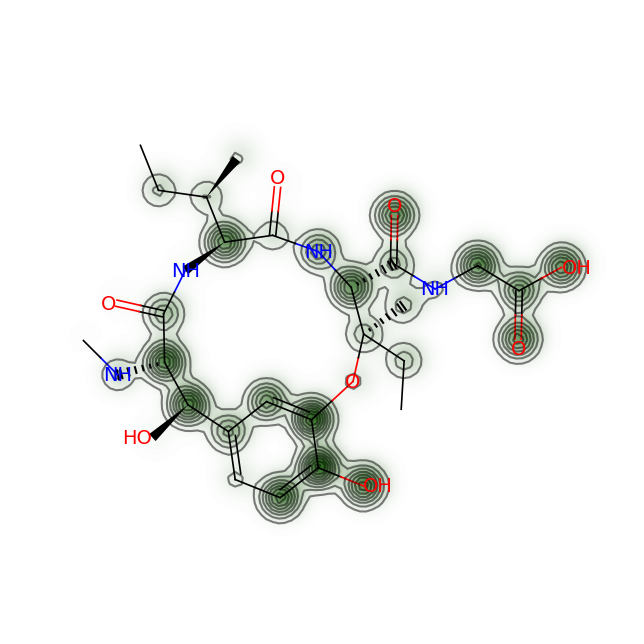

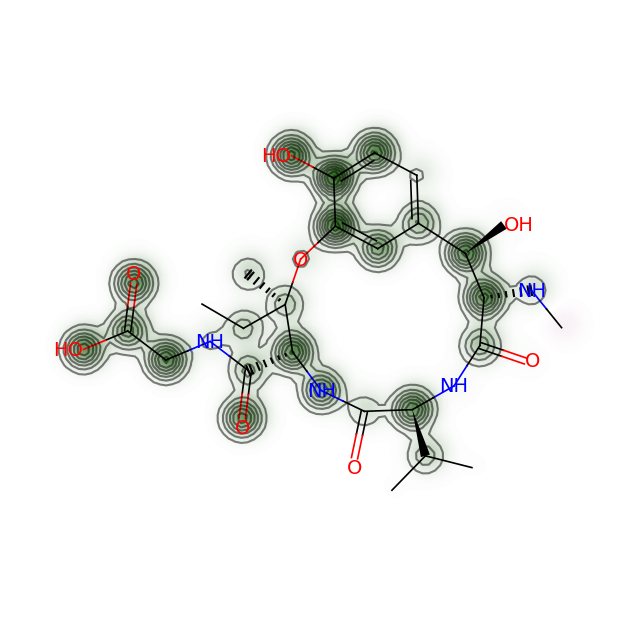

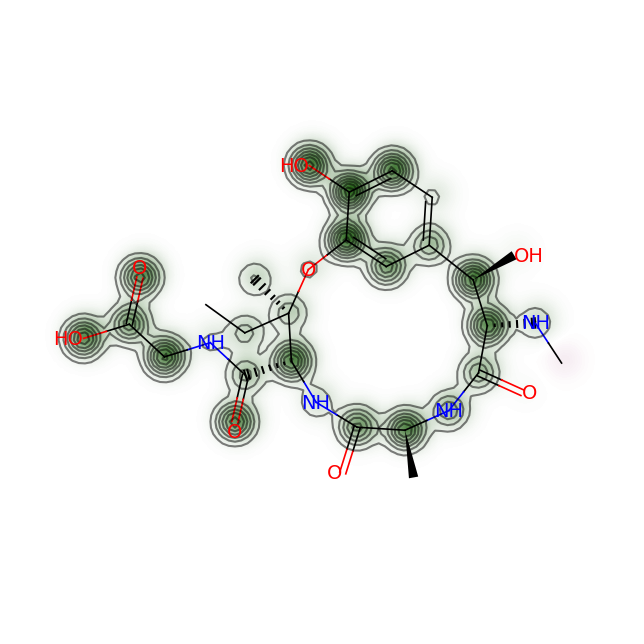

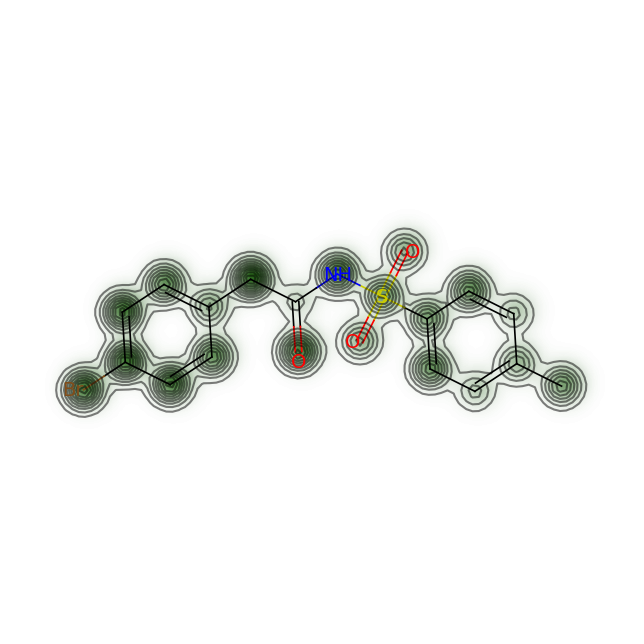

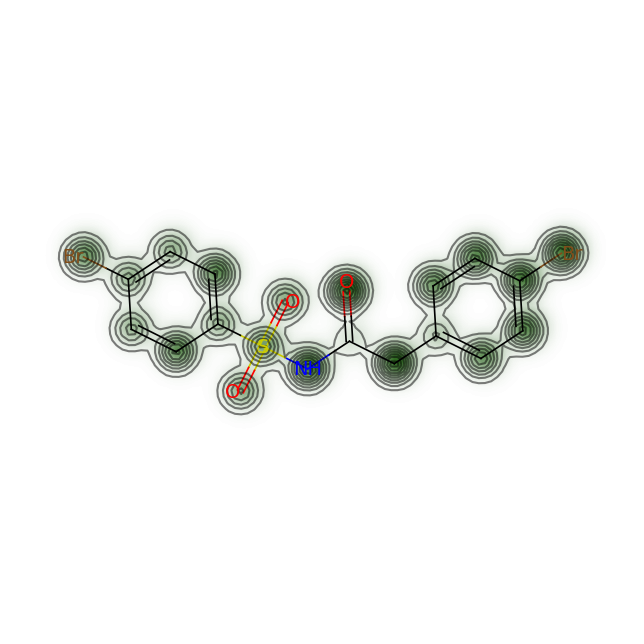

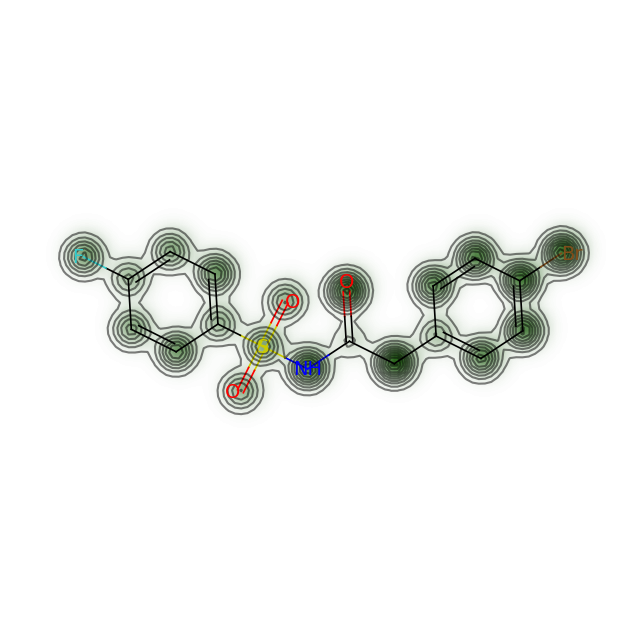

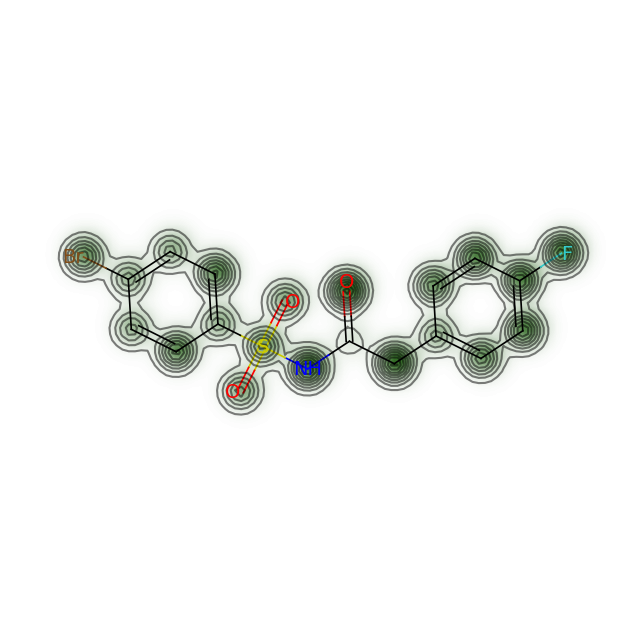

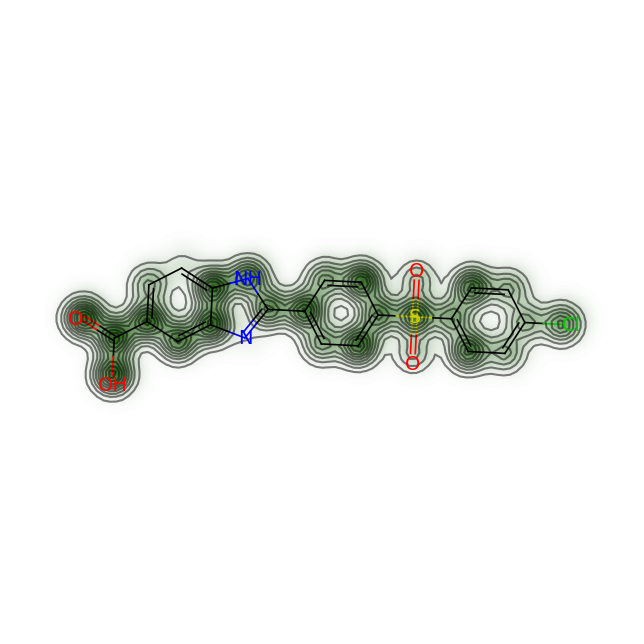

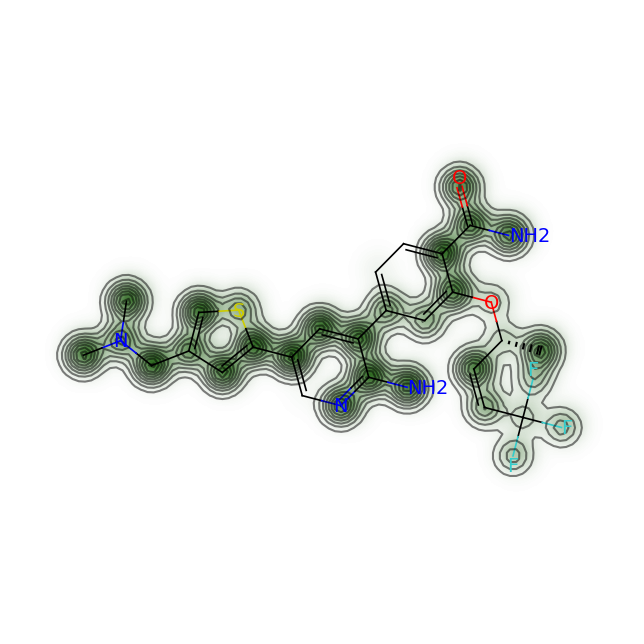

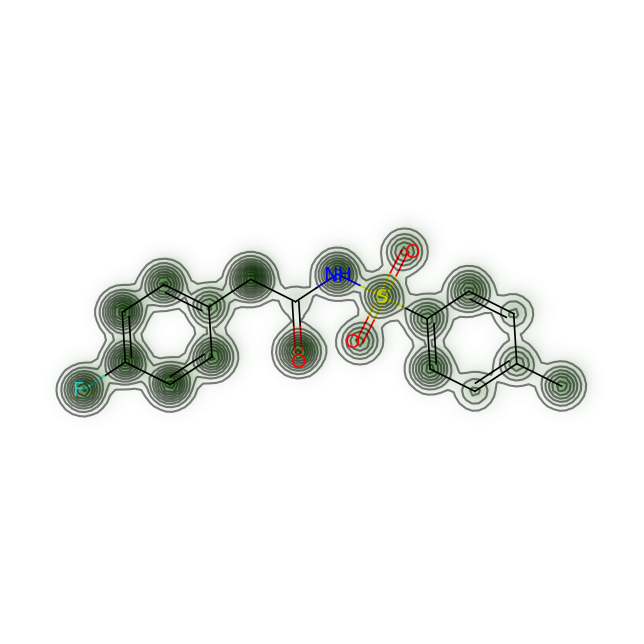

In [ ]:
vis_contribs(mols, mol_df, 'smi')

In [58]:


model.save_checkpoint()


,index,compound_id,smiles,type,standard_value,assay_id,assay_type,assay_description,document_id,abstract,target_ensemble_id
0,0,CHEMBL570841,N=C1NC(=O)/C(=C/c2ccc(O)cc2)S1,IC50,12000.0,CHEMBL3377973,B,In vitro inhibition of purified recombinant Mr...,CHEMBL3352588,"During the last decade, the use of small molec...",ENSG00000020922
1,1,CHEMBL570841,N=C1NC(=O)/C(=C/c2ccc(O)cc2)S1,IC50,66000.0,CHEMBL3377972,B,Inhibition of Mre11 exonuclease activity (unkn...,CHEMBL3352588,"During the last decade, the use of small molec...",ENSG00000020922
2,0,CHEMBL4128424,O=C(COc1ccc2c(-c3ccccc3)cc(=O)oc2c1)NN1C(=O)CS...,IC50,2890.0,CHEMBL4123910,B,Inhibition of tubulin beta polymerization in h...,CHEMBL4118208,A new set of 4-phenylcoumarin derivatives was ...,ENSG00000196230
3,1,CHEMBL107,COc1cc2c(c(OC)c1OC)-c1ccc(OC)c(=O)cc1[C@@H](NC...,IC50,4590.0,CHEMBL4259781,B,Inhibition of tubulin beta polymerization in h...,CHEMBL4257538,"A novel series of sulfonamide derivatives, cou...",ENSG00000196230
4,2,CHEMBL4127437,COc1cc(C2SCC(=O)N2NC(=O)COc2ccc3c(-c4ccccc4)cc...,IC50,6130.0,CHEMBL4123910,B,Inhibition of tubulin beta polymerization in h...,CHEMBL4118208,A new set of 4-phenylcoumarin derivatives was ...,ENSG00000196230
...,...,...,...,...,...,...,...,...,...,...,...
13747,995,CHEMBL7976,O=C(/C=C/c1ccccc1)c1ccccc1,IC50,620000.0,CHEMBL4307262,B,Inhibition of tubulin polymerization (unknown ...,CHEMBL4304785,"Curcumin (CU), an edible natural pigment from ...",ENSG00000261456
13748,996,CHEMBL107,COc1cc2c(c(OC)c1OC)-c1ccc(OC)c(=O)cc1[C@@H](NC...,IC50,800000.0,CHEMBL816885,F,Inhibitory concentration required against tubu...,CHEMBL1134259,"A series of 2',3',4',6,7-substituted 2-aryl qu...",ENSG00000261456
13749,997,CHEMBL18869,COc1cccc(-c2nc(O)c3cc(OC)ccc3n2)c1,IC50,4900000.0,CHEMBL816885,F,Inhibitory concentration required against tubu...,CHEMBL1134259,"A series of 2',3',4',6,7-substituted 2-aryl qu...",ENSG00000261456
13750,998,CHEMBL278647,COc1cccc(-c2nc(O)c3cc(OC)c(OC)cc3n2)c1,IC50,6500000.0,CHEMBL816885,F,Inhibitory concentration required against tubu...,CHEMBL1134259,"A series of 2',3',4',6,7-substituted 2-aryl qu...",ENSG00000261456


largest cluster: Cluster 0, Size: 418
Cluster 0: The global pandemic of drug-sensitive cancers and the increasing threat from drug-resistant cancers make an urgent need to develop more effective anti-cancer candidates. Quinolone derivatives possess promising anti-cancer activity, and some of them have already been approved to treat cancers or under clinical trials. Hybridization of quinolone with other anti-cancer pharmacophores may provide more efficient anti-cancer candidates, so quinolone hybrids worth to be investigated. In this review, the recent advances in the development of novel quinolone hybrids as potential anti-cancer agents are highlighted, and the structure-activity relationship is also discussed to provide an insight for further development of more active quinolone hybrids.
Cluster 1: A series of 3,4-disubstituted piperidine derivatives were obtained based on a conformational restriction strategy and a lead compound, <b>A12</b>, that exhibited potent in vitro and in vivo

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


1247
1247
False
Structure-based design and synthesis of the 3,4'-bispyridinylethylene series led to the discovery of 3-isoquinolinylpyridine 13a as a potent PKB/Akt inhibitor with an IC(50) of 1.3nM against Akt1. Compound 13a shows excellent selectivity against distinct families of kinases such as tyrosine kinases and CAMK, and displays poor to marginal selectivity against closely related kinases in the AGC and CMGC families. Moreover, 13a demonstrates potent cellular activity comparable to staurosporine, with IC(50) values of 0.42 and 0.59microM against MiaPaCa-2 and the Akt1 overexpressing FL5.12-Akt1, respectively. Inhibition of phosphorylation of the Akt downstream target GSK3 was also observed in FL5.12-Akt1 cells with an EC(50) of 1.5microM. The X-ray structures of 12 and 13a in complex with PKA in the ATP-binding site were determined.


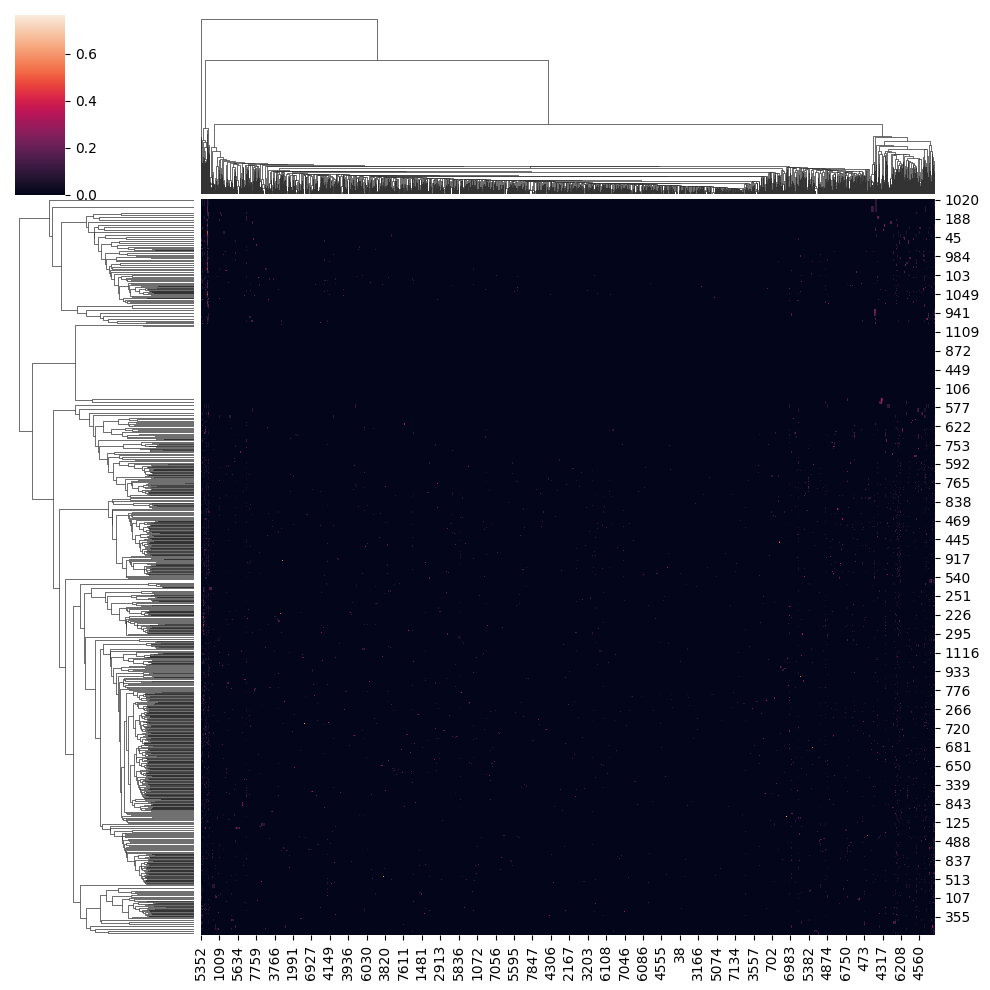

In [67]:
"""
insert code here that
1. retrieves the terms for all the assays that are relevant to the target the user picked.
2. clusters the assays according to their descriptive terms
3. plots the clusters (set n_clusters = 10)
4. prints out the title of one assay from each cluster.
"""
#getting information from the database
target_list = pd.read_json('http://mount.eastus.cloudapp.azure.com:1808/all_compounds')
display(target_list)

three_col_list = target_list[['assay_id', 'assay_description', 'abstract']].copy()
#getting just the Assay descriptions to prep for clustering
unique_list = []
for index, row in three_col_list.iterrows():
    if (row["assay_id"], row["assay_description"], row["abstract"]) in unique_list:
        continue
    else:
        unique_list.append((row["assay_id"], row["assay_description"], row["abstract"]))

Assay_Descriptions = [abstract for (assay_ids, assay_name, abstract) in unique_list]
Assay_Descriptions_Joined = ':: '.join(Assay_Descriptions)
#making the descriptions into one list
Assay_Descriptions_List = Assay_Descriptions
#the countVectorizer needed for the other vectorizer
Assay_Count_Vect = CountVectorizer()
Assay_Train_Counts = Assay_Count_Vect.fit_transform(Assay_Descriptions_List)
n_clusters = 20
X = Assay_Train_Counts.toarray()
#the second vectorizier (tfidf transformer)
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(Assay_Train_Counts)
tf_idf_vector = tfidf_transformer.transform(Assay_Train_Counts)

ward = AgglomerativeClustering(
    n_clusters = n_clusters, linkage="ward", connectivity=None, compute_full_tree= True,compute_distances= True
)
ward.fit(X)

unique_labels, counts = np.unique(ward.labels_, return_counts=True)
cluster_sizes = dict(zip(unique_labels, counts))

largest_cluster_label = max(cluster_sizes, key=cluster_sizes.get)
largest_cluster_size = cluster_sizes[largest_cluster_label]

print(f"largest cluster: Cluster {largest_cluster_label}, Size: {largest_cluster_size}")

cluster_labels = ward.fit_predict(tf_idf_vector.toarray())

cluster_assay_descriptions = {}
for cluster_label, assay_description in zip(cluster_labels, Assay_Descriptions):
    if cluster_label not in cluster_assay_descriptions:
        cluster_assay_descriptions[cluster_label] = []
    cluster_assay_descriptions[cluster_label].append(assay_description)

sorted_clusters = sorted(cluster_assay_descriptions.keys())
#getting and showing the cluster labels
for cluster_label in sorted_clusters:
    assay_descriptions = cluster_assay_descriptions[cluster_label]
    print(f"Cluster {cluster_label}: {assay_descriptions[0]}")

X_Hist = ward.distances_
kernel = stats.gaussian_kde(X_Hist)
print(kernel(X_Hist))

df_idf = pd.DataFrame(tfidf_transformer.idf_,index=Assay_Count_Vect.get_feature_names_out(),columns=["idf_weights"])
df_idf.sort_values(by=['idf_weights'])

count_vector=Assay_Count_Vect.transform(Assay_Descriptions_List)

tf_idf_vector=tfidf_transformer.transform(count_vector)
print(tf_idf_vector)

feature_names = Assay_Count_Vect.get_feature_names_out()

first_document_vector=tf_idf_vector[0]

df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)
#showing the Graph
seaborn.clustermap(tf_idf_vector.toarray(),method='ward')

print(len(cluster_labels))
print(len(Assay_Descriptions))
print(cluster_assay_descriptions[4][0] == cluster_assay_descriptions[4][1])
print(cluster_assay_descriptions[4][9])